## Building the simulation model

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random as rd
import numpy as np
from math import ceil
from pylab import *
%matplotlib inline

def find_distance(person, door): #function to find distance between a person and a door
    '''
    Find the distance between two given points - use case: find distance between person and door
    
    Inputs:
        person: list of coordinates [x,y]
        door: list of coordinates [x,y]
    Output:
        distance: float, the distance between the person and the door
    '''
    squared_distance = (door[0]-person[0])**2 + (door[1] - person[1])**2
    distance = squared_distance**0.5
    #distance between two points (x1, y1) and (x2, y2): sqrt((x2-x1)^2 + (y2-y1)^2)
    return distance

class CrowdEgress:

    def __init__(self, room_size, pop_density, num_door, door_size, is_random): 
        '''
        Create a new CrowdEgress object. People is initially distributed randomly across the room.

        Inputs:
            room_size(positive integer): Length of a side of the square room
            
            pop_density(float - between 0 and 1): The initial density of the people in the room
            
            num_door(positive integer): Number of doors in the room
            
            door_size(int - 0<door_size<6): The capacity of the door - the number of people able to escape at a time
            
            is_random(bool): Whether we apply the random or equal door distribution strategy
        '''
        self.size = room_size
        self.density = pop_density
        self.num_door = num_door
        self.door_size = door_size
        self.is_random = is_random
        self.config = np.zeros([self.size, self.size])
        self.next_config = np.zeros([self.size, self.size])
        self.list_doors = [] #list containing coordinates of all the doors
        self.num_people = 0 #number of people left in the room
        self.time_step = 0
        
        if self.num_door > (self.size-1)*4: #we can't have more door cells than possible wall cells
            raise ValueError("Too many doors!")
    def initialize(self):
        #First, we define where walls are. Each wall will have length of (self.size-1) so they fit together 
        wall_up=[]
        wall_right=[]
        wall_down=[]
        wall_left=[]
        for i in range(self.size-1):
            wall_up.append([0,i])
            wall_right.append([i, self.size-1])
            wall_down.append([self.size-1, i+1])
            wall_left.append([i+1, 0])
        walls = []
        walls.append(wall_up)
        walls.append(wall_right)
        walls.append(wall_down)
        walls.append(wall_left)
        
        #Now we define where the doors are. Doors will always be on the walls.
        #We have two strategies: distributing doors equally on each wall, or randomly
        #We first decide how many doors are on each wall
        doors_on_wall=[] #list to contain how many doors there are on each wall
        total_doors = self.num_door
        for i in range(4): #4 walls
            doors_distributed = int(ceil(total_doors/(4-i))) 
            total_doors -= doors_distributed #reduce the total number of doors left
            doors_on_wall.append(doors_distributed)
        
        #Now we decide how doors are placed on each wall
        if self.is_random == False: #distributing doors equally
            for i in range(len(walls)):
                doors_on_this_wall = doors_on_wall[i]
                for j in range(doors_on_this_wall):
                    equal_portions = int(ceil((self.size-1)/(doors_on_this_wall+1)))
                    door_pos = walls[i][equal_portions*(j+1)]
                    #The formula above: divide length of wall with number of equal portions corresponding to number of 
                    #doors. For example, with 2 doors, we divide the wall into 3 equal portions, with doors separating them
                    #this ensures equal distribution
                    self.list_doors.append(door_pos)
        else: #distributing doors randomly
            for i in range(len(walls)):
                doors_on_this_wall = doors_on_wall[i]
                for j in range(doors_on_this_wall):
                    random_door_index = np.random.randint(0, self.size-1) #self.size-1 is the length of the wall
                    door_pos = walls[i][random_door_index]
                    self.list_doors.append(door_pos)
                    
        #Now we move on to populating the room with people. "People" cells will carry the value of the door they
        #are heading to - the closest door to them at the initial time t=0
        for x in range(self.size): #loop through all cells
            for y in range(self.size):
                #make sure people are not initiated inside the doors and generate people with probability = density:
                if [x,y] not in self.list_doors and rd.random()<self.density: 
                    #now we find the person's target door which is the closest door
                    shortest_distance = float("inf")
                    for i in self.list_doors:
                        dist = find_distance([x,y], i) 
                        if dist < shortest_distance:
                            shortest_distance = dist
                            target_door = self.list_doors.index(i)+1
                    #having found the target door, we make the person carry the number of the door
                    self.config[x,y] = target_door
                    self.num_people +=1
                else:
                    pass
        
        #Finally, for later graphing purposes, we have all doors take on the value of (num_door + 10) so they are different
        for i in self.list_doors:
            self.config[i[0],i[1]] = self.num_door + 10
                
        
    def update(self):
        self.next_config = np.zeros([self.size, self.size])
        #First, we create a list to record how many person passed through the door in each time step
        list_passed = [0 for i in range(self.num_door)]
        #Change all door values to 0 to run the function (loop through all cells to identify people)
        for i in self.list_doors:
            self.config[i[0],i[1]] = 0
        #loop through all cells, for each one get a list of possible moves if that cell contains a person.
        #Possible moves take the person closer to the target door
        for x in range(self.size):
            for y in range(self.size):
                state = int(self.config[x,y])
                 #if it's a person, that cell carries the value of the target door
                if state != 0:
                    moves = [] #list of possible moves
                    distance = find_distance([x,y], self.list_doors[state-1]) #calculate distance to minimize
                    for dx in [-1,0,1]: #loop through all 9 Moore neighbors
                        for dy in [-1,0,1]:
                            #we go through several conditions to check if the neighbors are valid:
                            #First: is the neighbor out of bounds? We need it to be in the room
                            out_of_bound=None
                            if (x+dx) in range(self.size) and (y+dy) in range(self.size):
                                out_of_bound = False
                            else:
                                out_of_bound = True
                            #Second: if the neighbor is in the room, is it an empty cell?
                            empty_cell = None
                            if out_of_bound == False and self.config[x+dx,y+dy]==0 and self.next_config[x+dx,y+dy]==0:
                                empty_cell=True
                            else:
                                empty_cell = False
                            #Third, if the neighbor is an empty cell in the room, is it closer to the target door?
                            closer = None
                            distance_neighbor = find_distance([x+dx, y+dy], self.list_doors[state-1])
                            if distance_neighbor < distance:
                                closer = True
                            else:
                                closer = False
                            #Finally, we want to make sure the neighbor is not coincidentally another door:
                            #this avoids running infinitely
                            is_door = None
                            if [x+dx, y+dy] in self.list_doors and [x+dx, y+dy]!=self.list_doors[state-1]:
                                is_door = True
                            else:
                                is_door = False
                            #If we have all the above conditions (empty cell, in room, not another door, closer):
                            if not out_of_bound and empty_cell and closer and not is_door:
                                #it is a possible move, append that move and the distance in a tuple
                                #distance at the beginning to minimize later on
                                moves.append((distance_neighbor,[x+dx, y+dy]))

                    if moves: #if there are possible moves:
                        best_move = min(moves)[1] #get the move with the shortest distance
                        #if the best move does not lead straight to a door:
                        if best_move not in self.list_doors:
                            #simply make the move
                            self.next_config[best_move[0], best_move[1]] = state
                        else: #if it does lead to a door: we need to check if the door is at capacity or not
                            if list_passed[state-1] < self.door_size: #if there's still space
                                self.next_config[x,y] = 0 #the person is evacuated
                                list_passed[state-1] +=1 #increment the number of people passed
                            else: #the door is at capacity  
                                index_best_move = moves.index(min(moves))
                                #remove the (failed) best move
                                moves.remove(moves[index_best_move])
                                if moves: #if there is still another move, we try it:
                                    new_best = min(moves)[1]
                                    #make the move - skip checking door capacity since this move can't lead to door
                                    self.next_config[new_best[0], new_best[1]] = state
                                else: #no other move: stay put
                                    self.next_config[x,y] = state

                    else: #no possible moves: stay put
                        self.next_config[x,y] = state

        #we have all doors take on the value of (num_door + 10) again
        for i in self.list_doors:
            self.config[i[0],i[1]] = self.num_door + 10
            self.next_config[i[0],i[1]] = self.num_door + 10
        #Update the states
        self.config, self.next_config = self.next_config, self.config
        #Increment time steps and subtract number of people evacuated
        self.time_step +=1
        self.num_people -= sum(list_passed)
        

    def observe(self):
        plt.cla()
        plt.imshow(self.config, vmin = 0, vmax = self.num_door + 10, cmap = plt.cm.Blues)
        plt.title("Step %i" %self.time_step)
        plt.show()






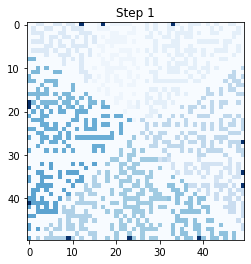

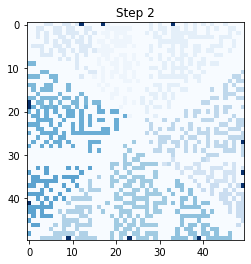

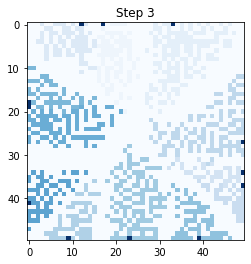

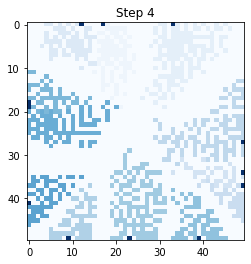

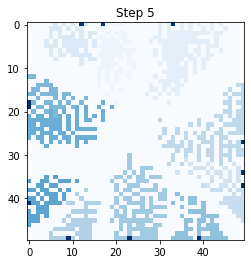

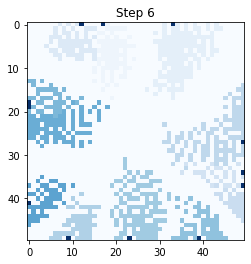

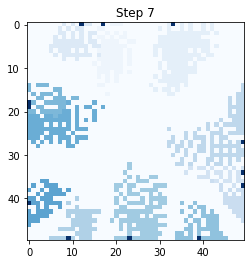

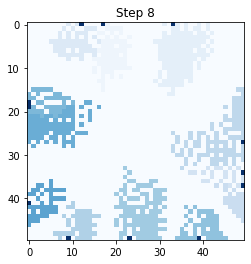

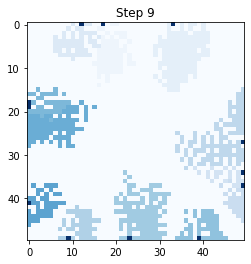

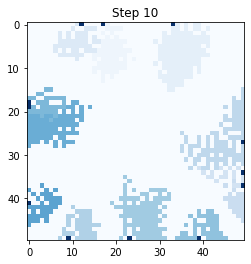

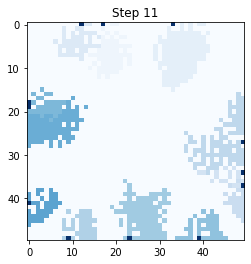

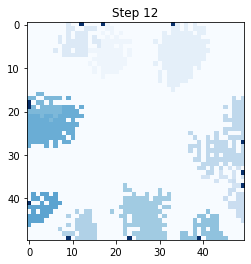

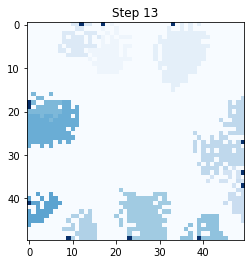

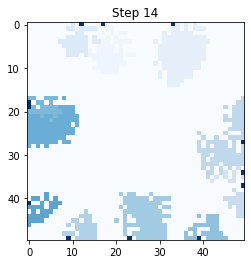

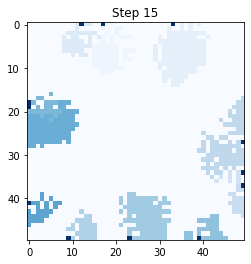

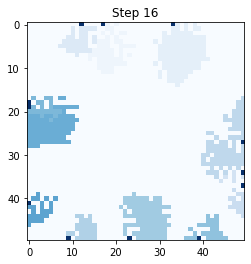

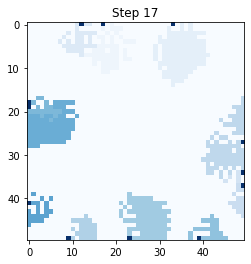

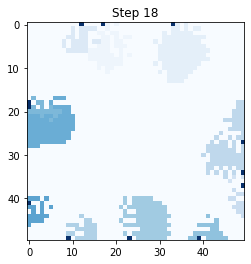

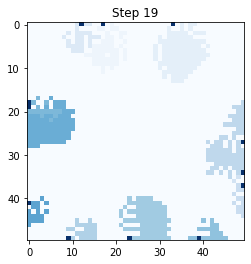

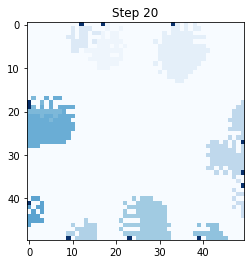

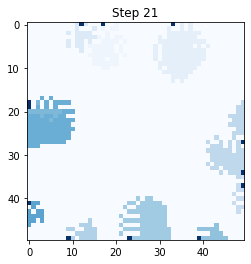

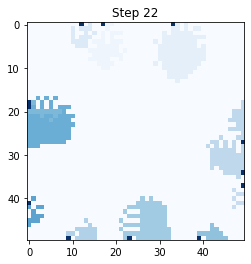

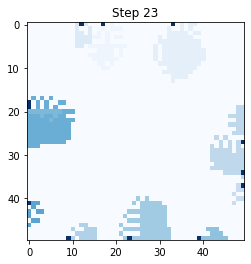

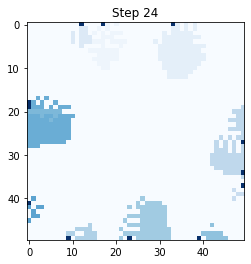

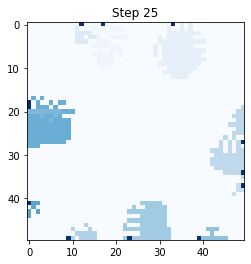

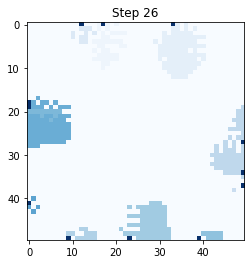

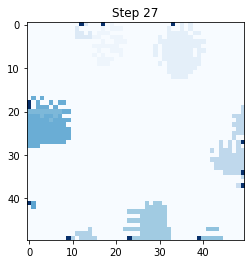

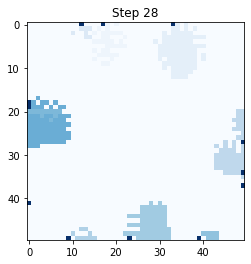

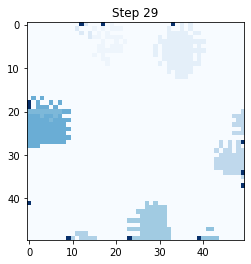

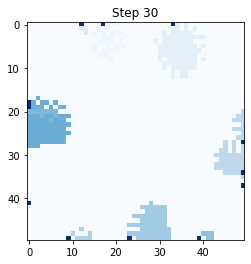

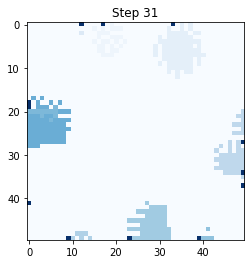

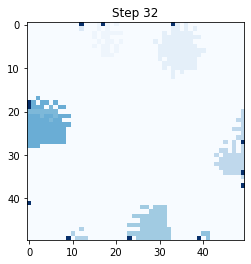

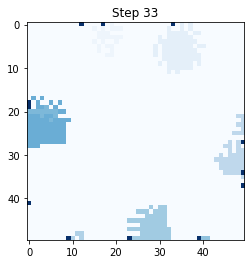

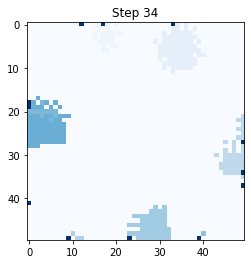

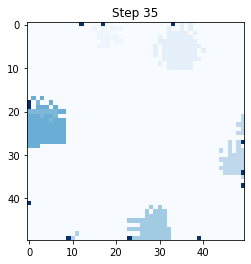

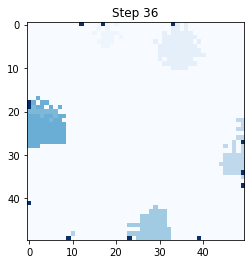

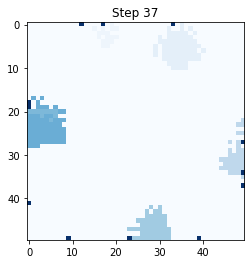

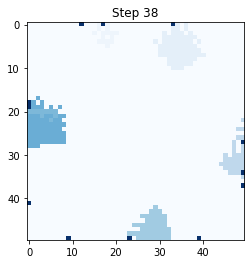

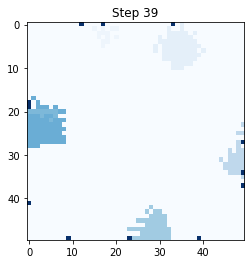

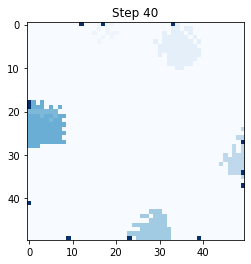

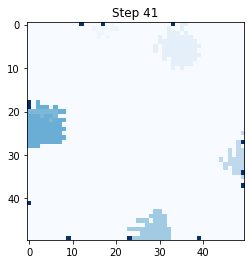

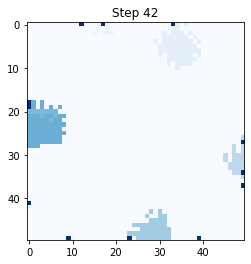

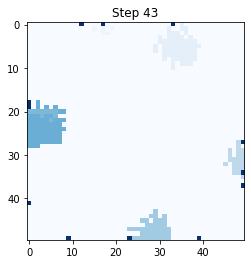

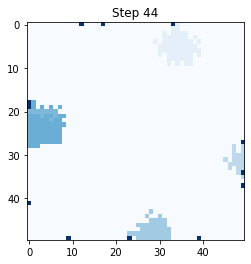

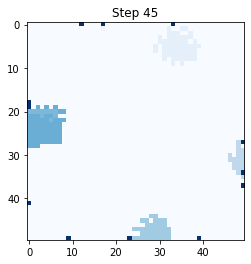

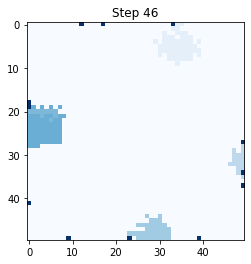

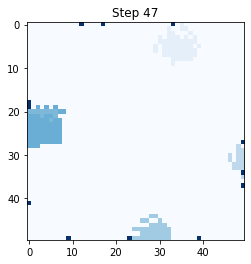

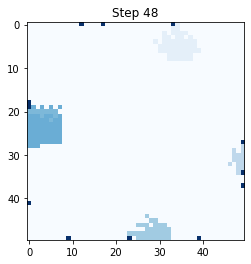

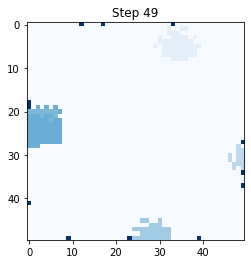

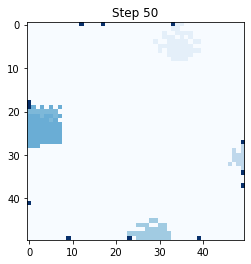

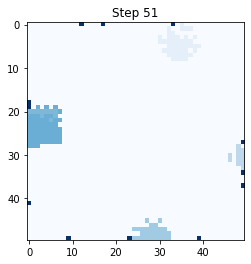

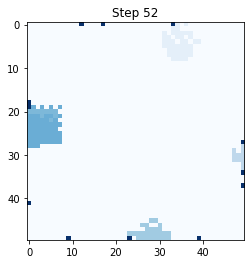

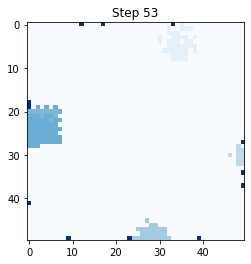

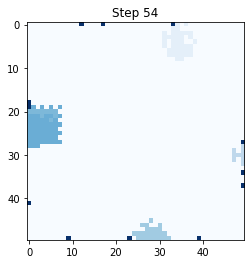

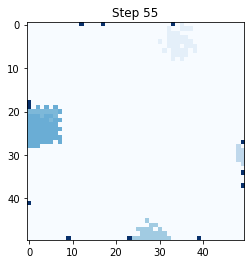

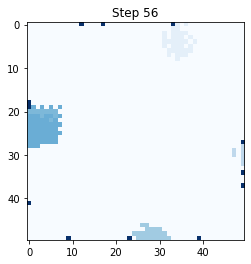

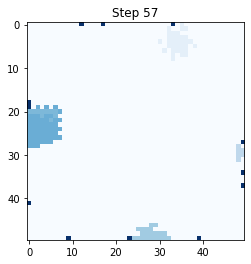

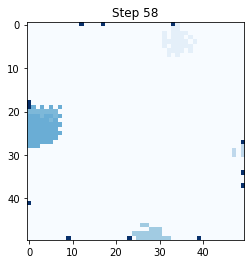

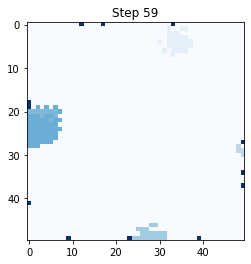

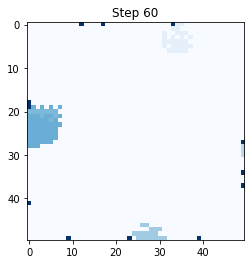

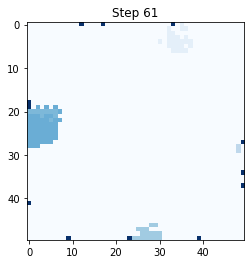

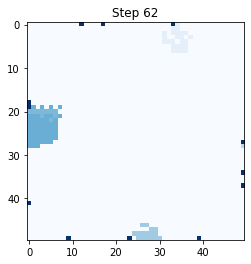

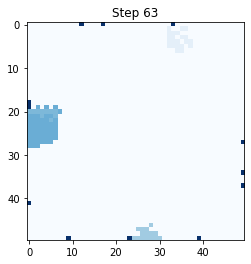

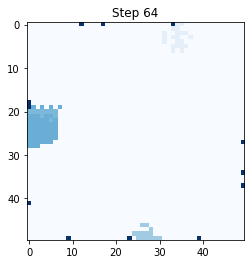

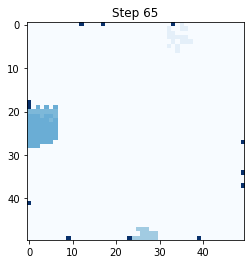

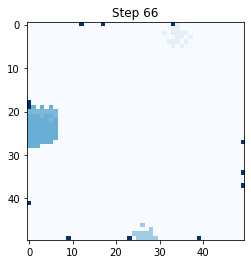

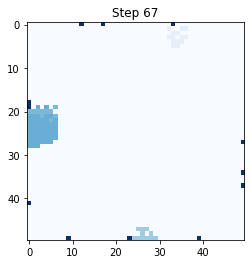

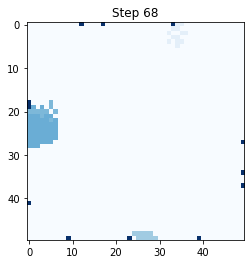

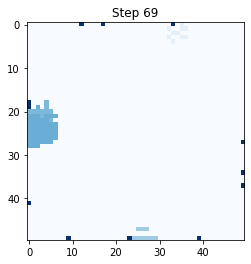

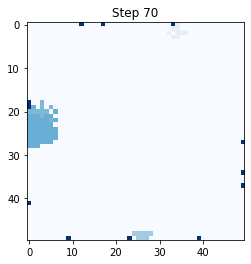

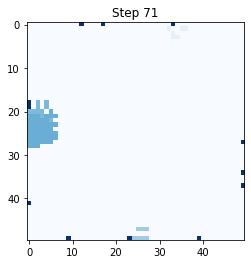

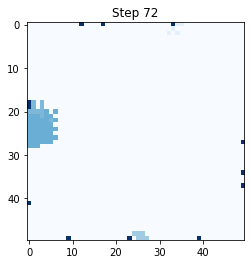

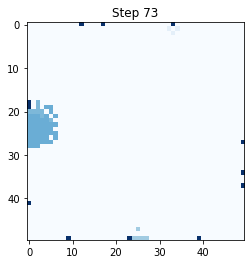

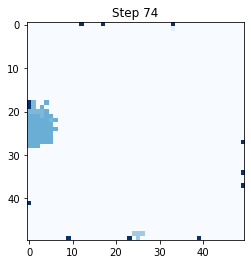

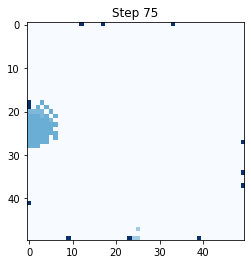

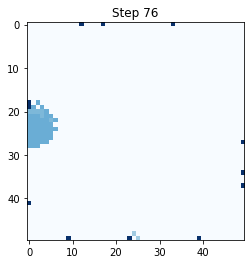

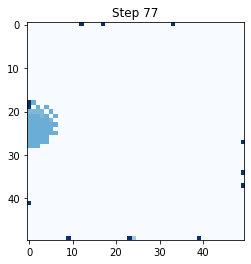

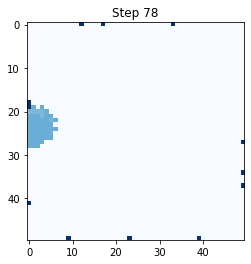

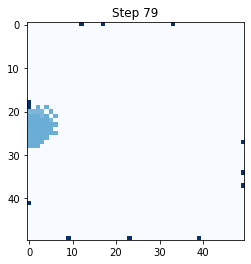

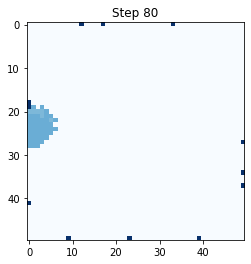

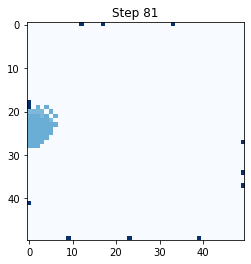

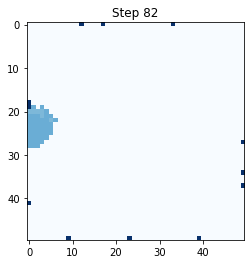

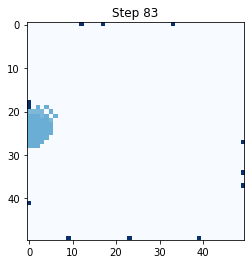

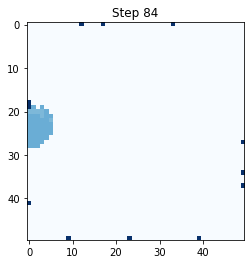

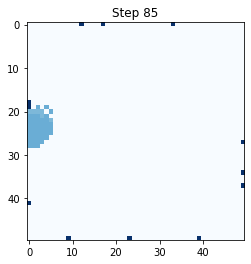

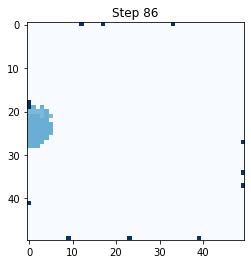

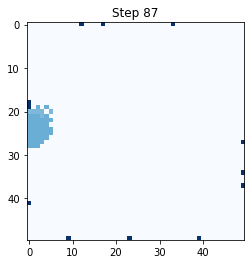

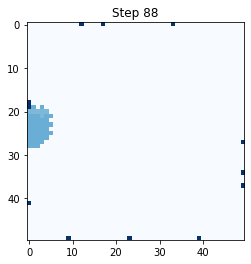

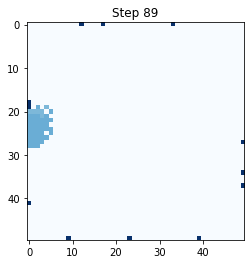

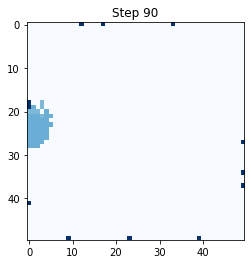

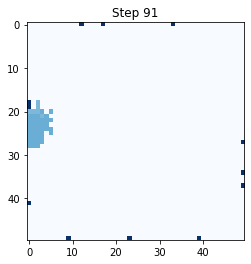

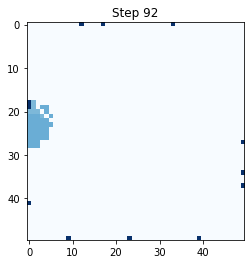

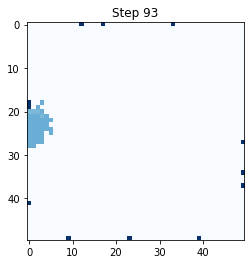

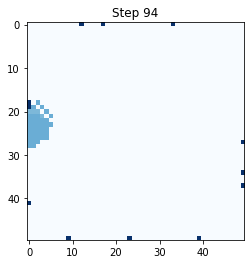

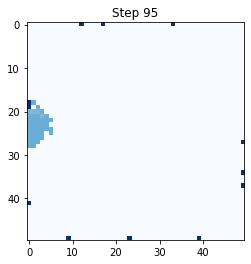

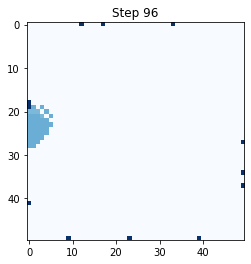

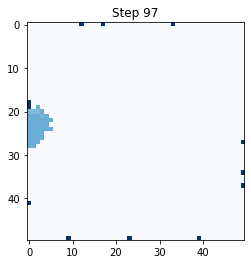

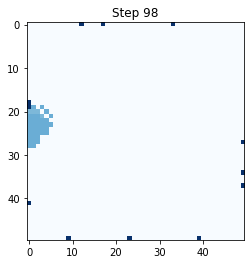

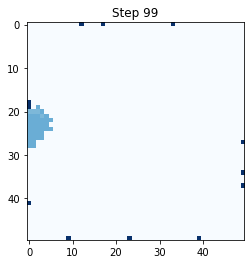

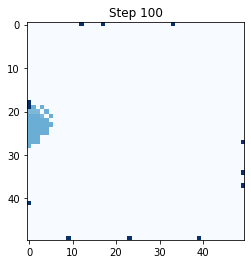

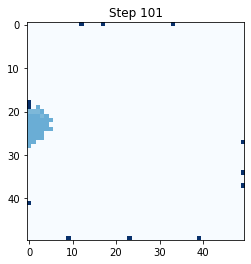

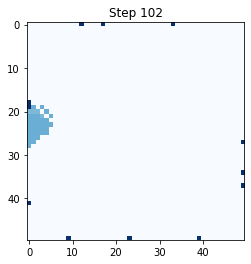

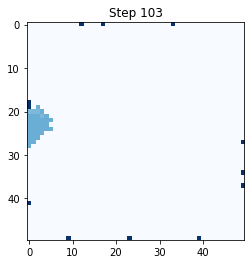

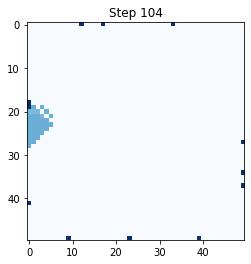

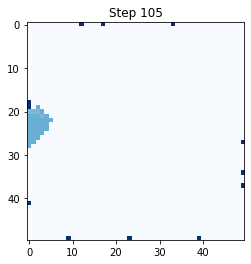

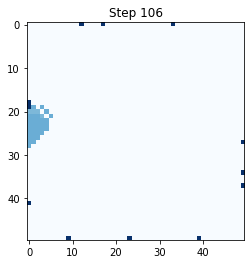

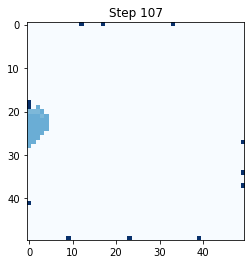

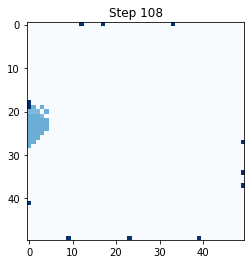

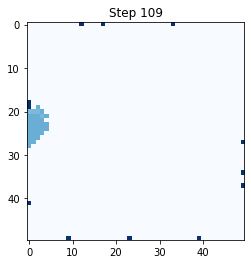

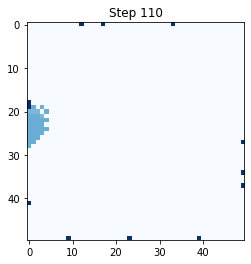

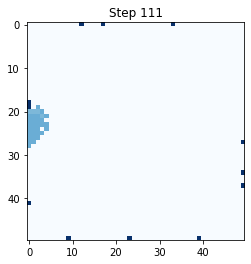

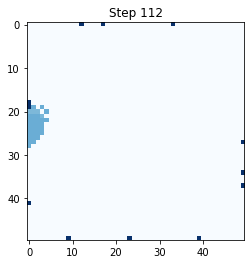

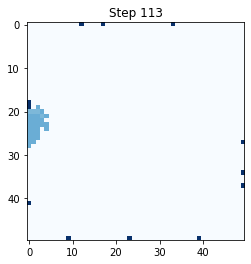

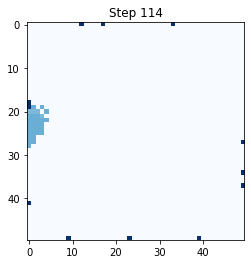

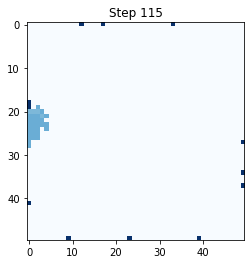

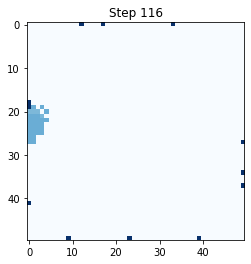

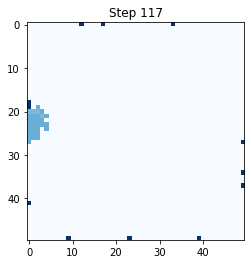

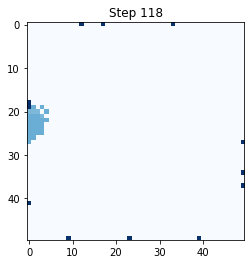

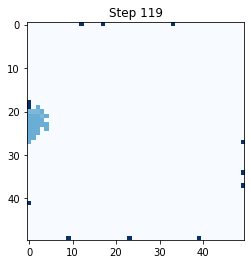

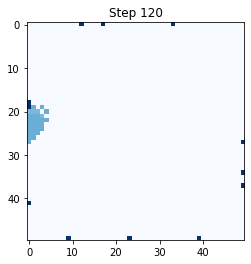

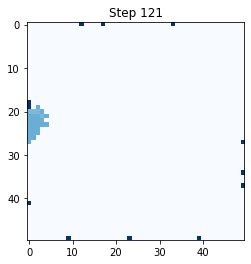

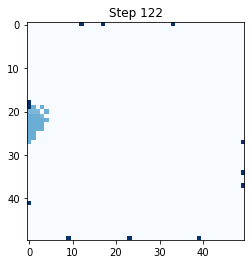

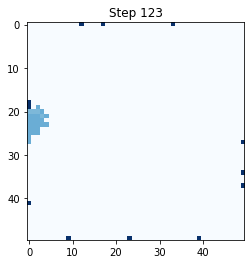

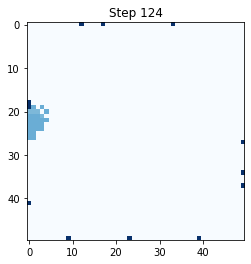

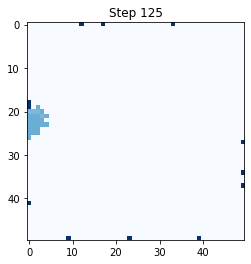

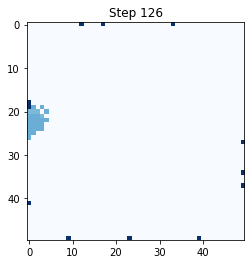

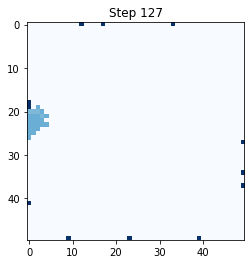

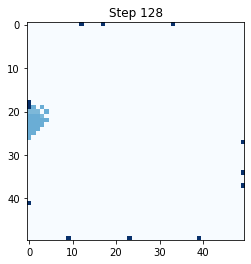

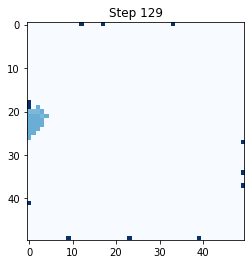

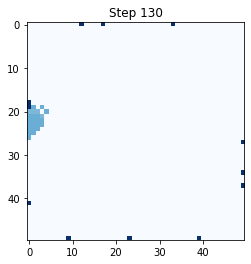

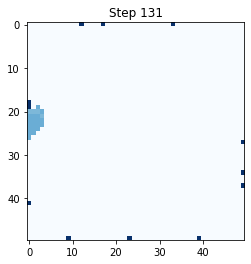

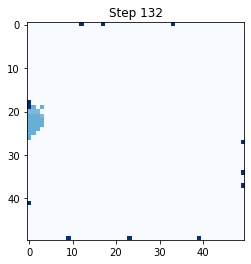

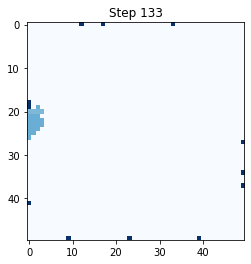

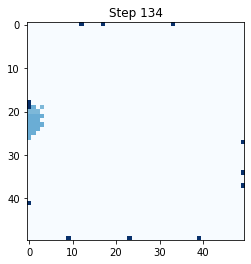

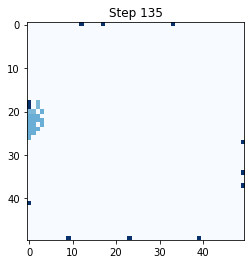

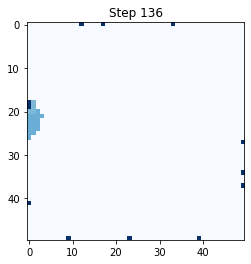

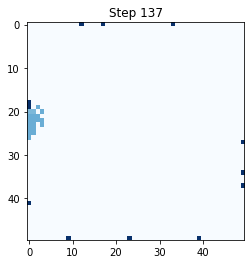

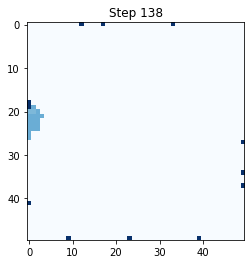

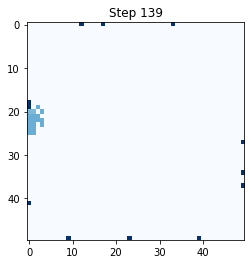

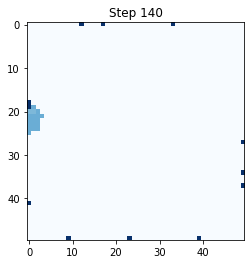

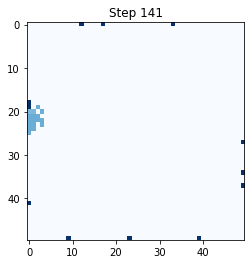

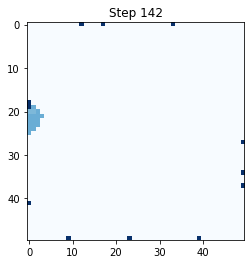

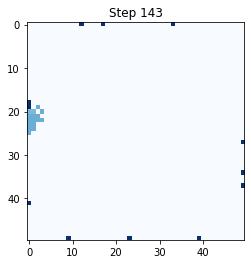

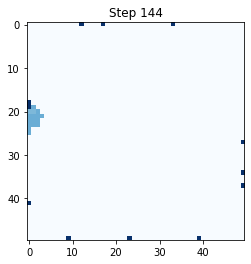

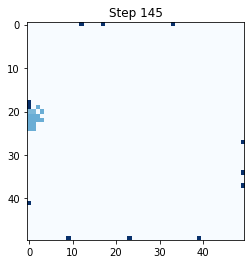

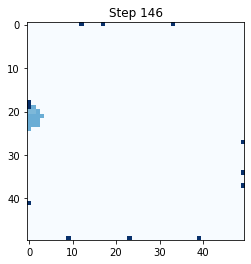

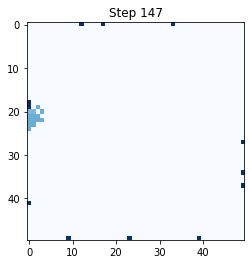

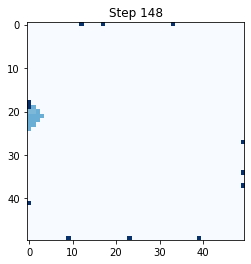

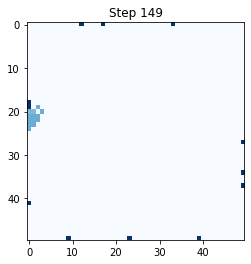

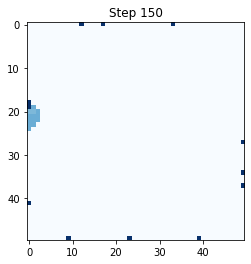

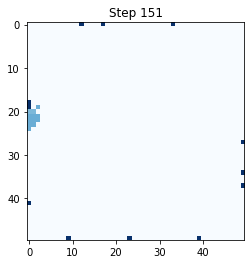

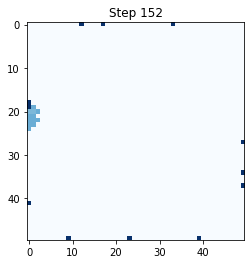

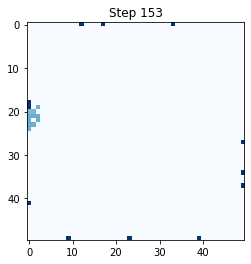

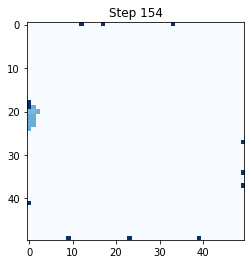

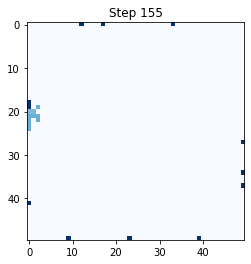

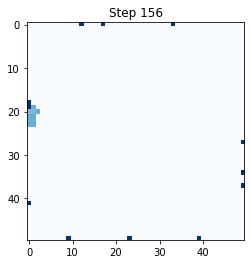

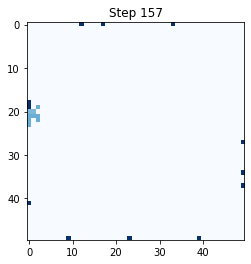

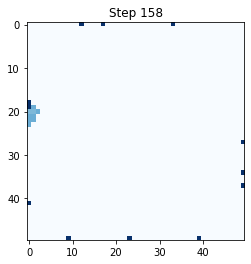

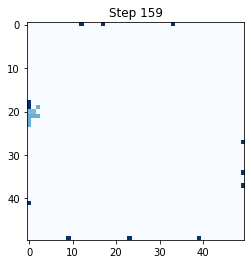

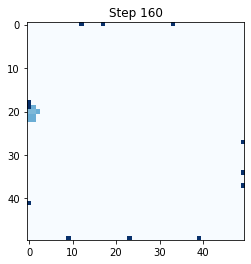

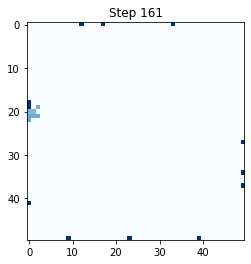

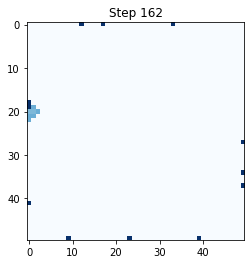

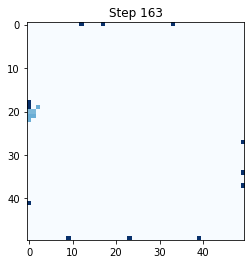

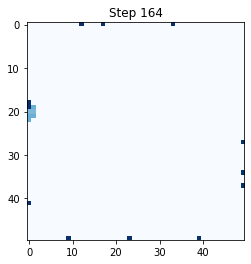

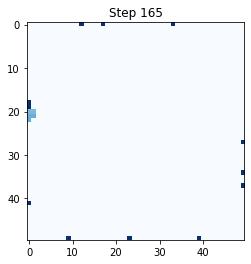

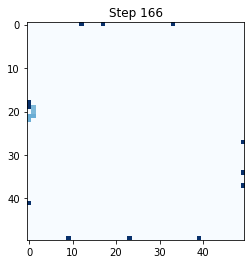

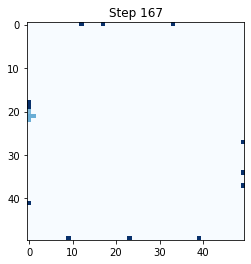

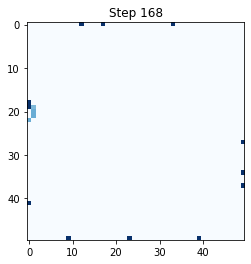

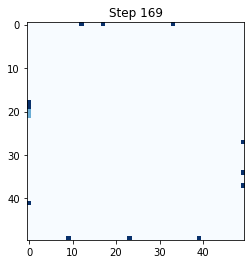

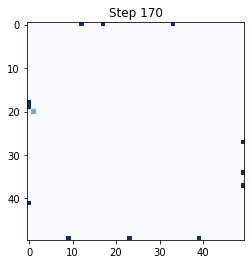

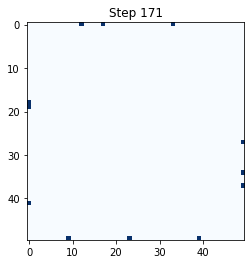

In [2]:
sim = CrowdEgress(50, 0.4, 12, 3,True)
sim.initialize()
while sim.num_people>0:
    sim.update()
    sim.observe()

## Varying variables and comparing two strategies

### 1. Size

In [3]:
list_time_size_random = [] #list to store the mean of finishing times with varying sizes
list_time_size_equal =[]
list_size = np.linspace(20,60,9)
for i in list_size:
    i = int(i)
    list_time_temp=[]
    for iter in range(10): #take 10 iterations and then take the mean
        sim = CrowdEgress(i, 0.4, 8, 3,False)
        sim.initialize()
        while sim.num_people>0:
            sim.update()
        list_time_temp.append(sim.time_step)
    list_time_size_equal.append(np.mean(list_time_temp))
    
for i in list_size:
    i = int(i)
    list_time_temp=[]
    for iter in range(10): #take 10 iterations and then take the mean
        is_infinite=False
        sim_random = CrowdEgress(i, 0.4, 8, 3,True)
        sim_random.initialize()
        while sim_random.num_people>0:
            sim_random.update()
            if np.array_equal(sim_random.config, sim_random.next_config): 
                #causes infinite runs - explained further in the report
                #in these cases, we simply stop the simulation and does not count the run
                sim_random.num_people=0
                is_infinite=True
        if not is_infinite:
            list_time_temp.append(sim_random.time_step)
        else:
            pass
    list_time_size_random.append(np.mean(list_time_temp))

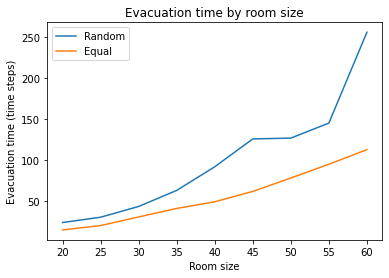

In [4]:
plt.figure()
plt.plot(list_size,list_time_size_random, label='Random')
plt.plot(list_size,list_time_size_equal, label='Equal')
plt.title("Evacuation time by room size")
plt.xlabel("Room size")
plt.ylabel("Evacuation time (time steps)")
plt.legend()
plt.show()

### 2. Density

In [5]:
list_time_density = [] #list to store the mean of finishing times with varying sizes
list_time_density_random = []
list_density = np.linspace(0.2,1,17)
for i in list_density:
    list_time_temp=[]
    for iter in range(10): #take 10 iterations and then take the mean
        sim = CrowdEgress(50, i, 8, 3,False)
        sim.initialize()
        while sim.num_people>0:
            sim.update()
        list_time_temp.append(sim.time_step)
    list_time_density.append(np.mean(list_time_temp))
    
for i in list_density:
    list_time_temp=[]
    for iter in range(10): #take 10 iterations and then take the mean
        is_infinite=False
        sim_random = CrowdEgress(50, i, 8, 3,True)
        sim_random.initialize()
        while sim_random.num_people>0:
            sim_random.update()
            if np.array_equal(sim_random.config, sim_random.next_config): 
                #causes infinite runs - explained further in the report
                #in these cases, we simply stop the simulation and does not count the run
                sim_random.num_people=0
                is_infinite=True
        if not is_infinite:
            list_time_temp.append(sim_random.time_step)
        else:
            pass
    list_time_density_random.append(np.mean(list_time_temp))

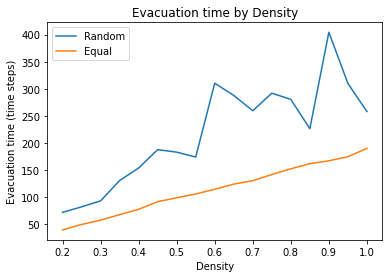

In [6]:
plt.figure()
plt.plot(list_density,list_time_density_random, label='Random')
plt.plot(list_density,list_time_density, label='Equal')
plt.title("Evacuation time by Density")
plt.xlabel("Density")
plt.ylabel("Evacuation time (time steps)")
plt.legend()
plt.show()

### 3. Number of doors

In [7]:
list_time_num_door = [] #list to store the mean of finishing times with varying sizes
list_time_num_door_random = []
list_num_door = np.linspace(2,16,8)
for i in list_num_door:
    i = int(i)
    list_time_temp=[]
    for iter in range(10): #take 10 iterations and then take the mean
        sim = CrowdEgress(50, 0.4, i, 3,False)
        sim.initialize()
        while sim.num_people>0:
            sim.update()
        list_time_temp.append(sim.time_step)
    list_time_num_door.append(np.mean(list_time_temp))
    
for i in list_num_door:
    i = int(i)
    list_time_temp=[]
    for iter in range(10): #take 10 iterations and then take the mean
        is_infinite=False
        sim_random = CrowdEgress(50, 0.4, i, 3,True)
        sim_random.initialize()
        while sim_random.num_people>0:
            sim_random.update()
            if np.array_equal(sim_random.config, sim_random.next_config): 
                #causes infinite runs - explained further in the report
                #in these cases, we simply stop the simulation and does not count the run
                sim_random.num_people=0
                is_infinite=True
        if not is_infinite:
            list_time_temp.append(sim_random.time_step)
        else:
            pass
    list_time_num_door_random.append(np.mean(list_time_temp))

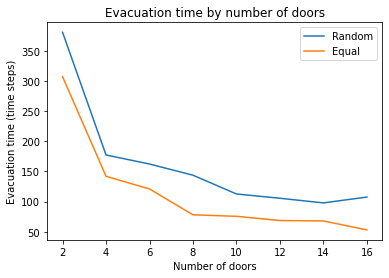

In [8]:
plt.figure()
plt.plot(list_num_door,list_time_num_door_random, label='Random')
plt.plot(list_num_door,list_time_num_door, label='Equal')
plt.title("Evacuation time by number of doors")
plt.xlabel("Number of doors")
plt.ylabel("Evacuation time (time steps)")
plt.legend()
plt.show()

### 4. Door size

In [9]:
list_time_door_size = [] #list to store the mean of finishing times with varying sizes
list_time_door_size_random = []
list_door_size = np.linspace(1,5,5)
for i in list_door_size:
    i = int(i)
    list_time_temp=[]
    for iter in range(20): #take 20 iterations and then take the mean
        sim = CrowdEgress(50, 0.4, 8, i,False)
        sim.initialize()
        while sim.num_people>0:
            sim.update()
        list_time_temp.append(sim.time_step)
    list_time_door_size.append(np.mean(list_time_temp))
    
for i in list_door_size:
    i = int(i)
    list_time_temp=[]
    for iter in range(20): #take 20 iterations and then take the mean
        is_infinite=False
        sim_random = CrowdEgress(50, 0.4, 8, i,True)
        sim_random.initialize()
        while sim_random.num_people>0:
            sim_random.update()
            if np.array_equal(sim_random.config, sim_random.next_config): 
                #causes infinite runs - explained further in the report
                #in these cases, we simply stop the simulation and does not count the run
                sim_random.num_people=0
                is_infinite=True
        if not is_infinite:
            list_time_temp.append(sim_random.time_step)
        else:
            pass
    list_time_door_size_random.append(np.mean(list_time_temp))

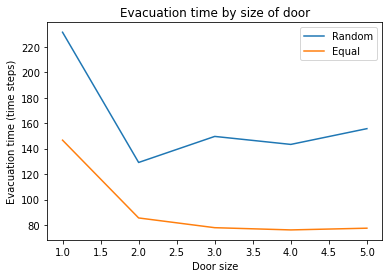

In [10]:
plt.figure()
plt.plot(list_door_size,list_time_door_size_random, label='Random')
plt.plot(list_door_size,list_time_door_size, label='Equal')
plt.title("Evacuation time by size of door")
plt.xlabel("Door size")
plt.ylabel("Evacuation time (time steps)")
plt.legend()
plt.show()

## Examine the distribution of evacuation times

In [11]:
#We run two strategies with a fixed set of parameters 100 times each to get the distribution
dist_random = []
dist_equal = []

for iter in range(100): #take 100 iterations 
    sim = CrowdEgress(50, 0.4, 8, 3,False)
    sim.initialize()
    while sim.num_people>0:
        sim.update()
    dist_equal.append(sim.time_step)
    

for iter in range(100): #take 100 iterations 
    is_infinite=False
    sim_random = CrowdEgress(50, 0.4, 8, 3,True)
    sim_random.initialize()
    while sim_random.num_people>0:
        sim_random.update()
        if np.array_equal(sim_random.config, sim_random.next_config): 
            #causes infinite runs - explained further in the report
            #in these cases, we simply stop the simulation and does not count the run
            sim_random.num_people=0
            is_infinite=True
    if not is_infinite:
        dist_random.append(sim_random.time_step)
    else:
        dist_random.append(0)


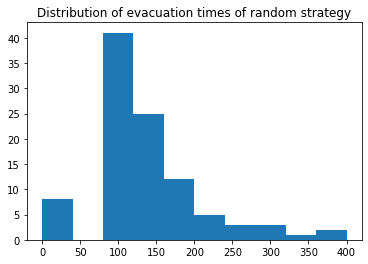

In [12]:
plt.hist(dist_random)
plt.title("Distribution of evacuation times of random strategy")
plt.show()

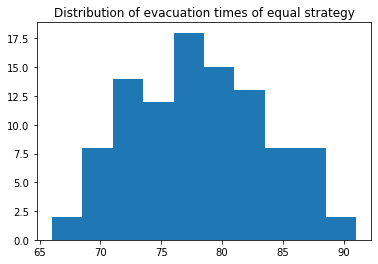

In [13]:
plt.hist(dist_equal)
plt.title("Distribution of evacuation times of equal strategy")
plt.show()

In [14]:
#Run with another set of parameters to see if there's any further insights
#We run two strategies with a fixed set of parameters 100 times each to get the distribution
dist_random2 = []
dist_equal2 = []

for iter in range(100): #take 100 iterations 
    sim = CrowdEgress(40, 0.5, 12, 3,False)
    sim.initialize()
    while sim.num_people>0:
        sim.update()
    dist_equal2.append(sim.time_step)
    

for iter in range(100): #take 100 iterations 
    is_infinite=False
    sim_random = CrowdEgress(40, 0.5, 12, 3,True)
    sim_random.initialize()
    while sim_random.num_people>0:
        sim_random.update()
        if np.array_equal(sim_random.config, sim_random.next_config): 
            #causes infinite runs - explained further in the report
            #in these cases, we simply stop the simulation and does not count the run
            sim_random.num_people=0
            is_infinite=True
    if not is_infinite:
        dist_random2.append(sim_random.time_step)
    else:
        dist_random2.append(0)


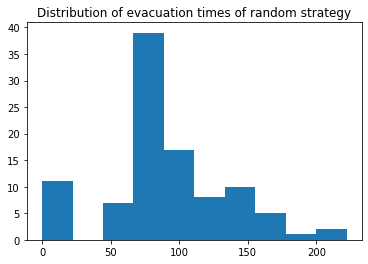

In [15]:
plt.hist(dist_random2)
plt.title('Distribution of evacuation times of random strategy')
plt.show()

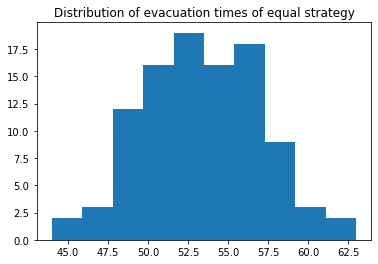

In [16]:
plt.hist(dist_equal2)
plt.title("Distribution of evacuation times of equal strategy")
plt.show()

## Theoretical analysis

In [17]:
def theoretical_analysis(size, density, num_door, door_size):
    #first, we find the distance from the mid point of the room to the door
    if int(ceil(num_door/4))%2 == 1: #number of door on the wall is odd
        dist_to_door= int(size/2)
    else: #number of door on the wall is even
        #find the distance from the middle point of the wall to the nearest door 
        a = size/2 - (size/(num_door+1))*((num_door-1)/2)
        #Use pythagorean theorem to find dist_to_door:
        dist_to_door = int(np.sqrt(a**2 + (size/2)**2))
    #now that we have the distance to the door, we find x
    x = ((2.5*dist_to_door - (size**2*density)/num_door)*(1-density**3))/(2.5*(1-density**3)-door_size)
    #with x, we find the time taken to get from initial position to the queue
    time_to_queue = x/(1-density**3)
    #We now find the time taken to get from the queue to the door and escape
    #first we find the length of the queue
    length_queue = (((size**2*density)/num_door) - x*door_size/(1-density**3))/2.5
    time_queue_to_escape = length_queue*door_size/5
    return time_to_queue + time_queue_to_escape

In [18]:
list_time_density_theo = [] #list to store the mean of theoretical finishing times with varying sizes
list_density = np.linspace(0.2,0.95,16) #we omit value of 1 since 1 already gave 100% certainty even with simulated results
for i in list_density:
    list_time_density_theo.append(theoretical_analysis(50, i, 8, 3))

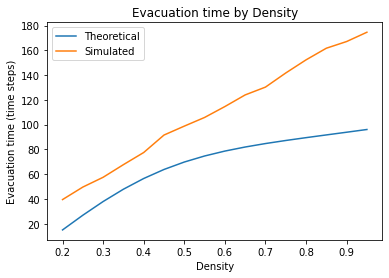

In [19]:
plt.figure()
plt.plot(list_density,list_time_density_theo, label='Theoretical')
plt.plot(list_density,list_time_density[:-1], label='Simulated')
plt.title("Evacuation time by Density")
plt.xlabel("Density")
plt.ylabel("Evacuation time (time steps)")
plt.legend()
plt.show()

## Calculate the confidence interval on the mean of evacuation time

This time, we simulate many sets of simulation results, take the mean of each, and then find the confidence interval of the resulting set of means. We will vary by density, since it has the most practical meaning: for existing rooms, it's next to impossible to change the room size or number of doors or door size, so the most actionable parameter will be the density of people in the room.

In [20]:
list_density = np.linspace(0.2,1,17)
dist_by_density_random=[]
dist_by_density_equal=[]

for density in list_density:
    dist_mean_equal=[]
    for i in range(20): #20 sets of data for 20 means
        dist_equal = []
        for iter in range(20): #take 20 iterations - too time consuming to take more
            sim = CrowdEgress(30, density, 12, 3,False)
            sim.initialize()
            while sim.num_people>0:
                sim.update()
            dist_equal.append(sim.time_step)
        dist_mean_equal.append(np.mean(dist_equal))
    dist_by_density_equal.append(dist_mean_equal)

for density in list_density:
    dist_mean_random=[]
    for i in range(20):
        dist_random = []
        for iter in range(20): #take 20 iterations 
            is_infinite=False
            sim_random = CrowdEgress(30, density, 12, 3,True)
            sim_random.initialize()
            while sim_random.num_people>0:
                sim_random.update()
                if np.array_equal(sim_random.config, sim_random.next_config): 
                    #causes infinite runs - explained further in the report
                    #in these cases, we simply stop the simulation and does not count the run
                    sim_random.num_people=0
                    is_infinite=True
            if not is_infinite:
                dist_random.append(sim_random.time_step)
            else:
                dist_random.append(0)
        dist_mean_random.append(np.mean(dist_random))
    dist_by_density_random.append(dist_mean_random)

In [21]:
#The cell above takes a lot of time to run, so I've stored the data here
random_data=[[18.0, 18.85, 18.5, 18.75, 17.7, 17.25, 19.0, 17.8, 18.3, 17.95, 18.0, 18.65, 18.8, 18.9, 17.8, 19.75, 18.0, 17.3, 20.2, 17.8], [23.05, 20.9, 24.9, 23.15, 22.0, 21.9, 23.75, 23.55, 22.55, 23.5, 24.3, 21.75, 21.1, 23.75, 23.75, 23.0, 23.35, 21.95, 23.55, 23.15], [26.45, 34.2, 31.2, 28.0, 28.5, 26.4, 26.5, 28.8, 27.5, 25.6, 27.75, 27.05, 25.6, 25.95, 27.7, 27.5, 28.95, 27.8, 27.6, 28.55], [36.05, 32.45, 31.0, 36.4, 32.3, 36.6, 32.6, 35.6, 30.5, 34.85, 33.65, 31.75, 31.1, 33.4, 32.15, 30.9, 33.3, 34.45, 33.4, 30.55], [44.4, 43.2, 42.5, 40.3, 40.7, 34.55, 38.6, 37.2, 33.55, 37.15, 36.0, 38.7, 34.4, 44.15, 40.75, 45.45, 38.3, 38.25, 39.8, 42.35], [41.85, 42.8, 42.95, 51.45, 46.75, 40.7, 49.45, 57.8, 43.35, 48.45, 50.6, 50.05, 42.25, 45.2, 51.85, 43.15, 46.2, 52.3, 45.95, 41.95], [52.25, 45.3, 46.4, 52.95, 56.7, 62.95, 63.4, 50.5, 50.25, 50.95, 51.05, 48.6, 53.4, 48.7, 53.45, 54.4, 47.9, 51.2, 53.8, 47.0], [64.3, 53.3, 62.35, 48.15, 63.35, 57.3, 51.0, 55.75, 47.7, 55.1, 52.5, 58.3, 56.8, 51.75, 52.8, 61.55, 53.25, 57.15, 57.75, 59.4], [75.95, 69.95, 70.35, 58.2, 62.15, 57.8, 68.5, 54.15, 76.0, 62.05, 65.6, 53.6, 58.8, 59.7, 56.5, 59.7, 65.95, 67.4, 73.25, 63.5], [65.3, 85.2, 70.0, 65.25, 69.95, 69.25, 69.4, 61.15, 57.55, 62.4, 58.1, 67.2, 70.3, 73.75, 65.55, 66.45, 63.95, 72.15, 79.35, 71.1], [76.1, 73.9, 66.0, 88.25, 63.95, 69.85, 79.45, 73.85, 63.55, 78.7, 59.95, 78.55, 65.65, 75.2, 83.55, 81.5, 75.7, 80.9, 79.75, 62.25], [97.05, 72.5, 71.9, 70.6, 78.4, 97.8, 88.0, 63.9, 72.2, 69.5, 67.3, 74.5, 67.65, 79.05, 64.1, 77.9, 62.25, 81.9, 76.2, 66.9], [92.35, 89.75, 104.7, 76.5, 84.45, 86.9, 69.4, 93.25, 86.65, 81.75, 94.2, 72.6, 75.25, 93.5, 80.4, 77.85, 87.15, 98.5, 77.45, 79.8], [80.6, 97.35, 77.25, 74.7, 86.25, 83.05, 88.75, 83.25, 64.8, 93.5, 76.2, 75.45, 64.45, 74.8, 92.45, 98.8, 87.7, 87.9, 81.6, 81.0], [84.95, 92.1, 90.85, 85.35, 102.95, 82.8, 101.85, 86.8, 107.75, 69.6, 86.95, 78.75, 83.25, 94.95, 83.9, 79.55, 91.9, 88.45, 88.0, 74.85], [95.85, 98.25, 106.6, 77.7, 93.3, 84.5, 93.45, 68.45, 75.75, 91.1, 94.95, 100.5, 83.1, 62.0, 90.4, 99.55, 90.7, 83.05, 81.7, 88.85], [71.65, 103.45, 86.95, 87.45, 97.65, 92.6, 102.35, 103.45, 95.7, 96.3, 82.25, 108.7, 86.15, 103.2, 95.1, 102.75, 80.6, 109.85, 118.7, 95.75]]
equal_data=[[13.8, 14.2, 14.25, 14.05, 14.3, 14.3, 14.05, 14.65, 14.0, 14.1, 14.15, 14.1, 14.3, 14.1, 14.1, 13.95, 14.45, 14.45, 14.15, 14.05], [16.75, 15.3, 16.0, 16.3, 15.35, 15.85, 15.5, 15.7, 16.15, 15.6, 16.3, 16.45, 16.5, 15.75, 15.85, 15.35, 16.05, 15.4, 16.35, 16.45], [18.65, 18.15, 18.3, 18.95, 18.3, 18.8, 18.15, 18.5, 18.15, 18.35, 18.3, 17.9, 18.4, 18.65, 18.25, 17.9, 18.7, 18.6, 18.45, 18.1], [20.65, 20.85, 21.25, 20.9, 21.05, 21.25, 21.25, 21.05, 21.3, 21.8, 21.6, 21.1, 20.85, 21.15, 21.1, 21.1, 21.1, 21.1, 21.8, 20.85], [23.9, 24.5, 24.9, 23.45, 24.6, 24.1, 23.7, 23.65, 24.6, 24.15, 23.75, 23.3, 24.25, 23.95, 24.45, 24.1, 23.95, 23.2, 24.15, 24.2], [27.6, 26.45, 27.4, 27.3, 26.2, 27.6, 26.75, 27.7, 27.25, 26.45, 26.65, 27.4, 26.3, 27.6, 26.75, 27.2, 26.2, 27.65, 26.9, 27.15], [28.85, 29.55, 29.35, 29.35, 30.1, 29.85, 29.6, 29.8, 30.15, 29.15, 29.8, 29.8, 30.3, 29.8, 29.95, 30.05, 29.7, 29.2, 30.85, 30.35], [31.9, 33.45, 33.4, 32.15, 32.05, 32.05, 32.35, 32.45, 32.1, 33.25, 33.4, 31.55, 32.5, 32.15, 32.6, 32.55, 32.5, 32.6, 31.95, 32.05], [35.45, 34.8, 35.2, 35.5, 35.5, 33.95, 35.05, 34.35, 35.45, 35.85, 35.5, 34.65, 36.15, 34.9, 34.2, 35.7, 35.4, 34.6, 35.7, 34.55], [38.2, 38.2, 36.65, 37.85, 37.5, 38.1, 38.05, 37.2, 37.15, 38.25, 38.85, 37.55, 38.6, 36.8, 37.3, 37.0, 37.85, 37.15, 37.65, 37.6], [39.35, 40.5, 40.1, 39.75, 40.1, 40.15, 40.25, 40.5, 40.55, 40.55, 39.45, 40.05, 40.05, 40.35, 39.45, 39.8, 40.45, 39.7, 40.85, 40.4], [42.0, 43.1, 41.95, 42.4, 42.5, 42.15, 42.55, 41.5, 42.7, 42.8, 41.3, 42.65, 42.15, 42.0, 42.4, 41.9, 41.8, 42.3, 41.95, 42.0], [45.05, 44.0, 44.4, 45.35, 45.05, 44.05, 44.95, 45.0, 45.55, 44.9, 44.05, 44.2, 44.4, 45.45, 44.6, 44.85, 44.95, 45.85, 45.0, 44.55], [46.85, 47.25, 47.2, 48.1, 47.0, 47.1, 47.35, 46.65, 47.0, 46.9, 46.3, 47.25, 46.65, 46.9, 47.05, 45.9, 46.9, 45.85, 47.9, 46.35], [48.85, 48.3, 48.4, 49.4, 48.75, 49.8, 48.25, 47.95, 48.55, 48.75, 48.85, 48.6, 48.75, 47.8, 49.35, 47.8, 48.7, 49.35, 48.4, 48.95], [51.3, 50.45, 51.2, 50.2, 50.75, 51.5, 51.1, 50.5, 50.7, 50.85, 50.9, 50.9, 50.6, 50.9, 51.1, 50.55, 50.8, 50.5, 50.5, 51.1], [52.0, 52.0, 52.0, 52.0, 52.0, 52.0, 52.0, 52.0, 52.0, 52.0, 52.0, 52.0, 52.0, 52.0, 52.0, 52.0, 52.0, 52.0, 52.0, 52.0]]

In [22]:
#plotting the mean, upper and lower confidence interval (95%)
lst_mean=[]
lst_upper_confint=[]
lst_lower_confint=[]
for i in range(len(random_data)):
    lst_mean.append(np.mean(random_data[i]))
    lst_upper_confint.append(np.percentile(random_data[i],97.5))
    lst_lower_confint.append(np.percentile(random_data[i],2.5))

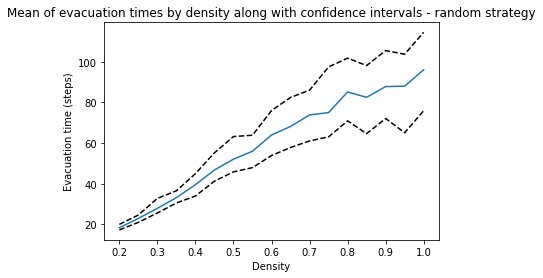

In [23]:
plt.figure()
plt.plot(list_density, lst_mean)
plt.plot(list_density, lst_upper_confint, 'k--')
plt.plot(list_density, lst_lower_confint, 'k--')
plt.title("Mean of evacuation times by density along with confidence intervals - random strategy")
plt.xlabel("Density")
plt.ylabel("Evacuation time (steps)")
plt.show()

In [24]:
#Do the same for the equal strategy
lst_mean_equal=[]
lst_upper_confint_equal=[]
lst_lower_confint_equal=[]
for i in range(len(random_data)):
    lst_mean_equal.append(np.mean(equal_data[i]))
    lst_upper_confint_equal.append(np.percentile(equal_data[i],97.5))
    lst_lower_confint_equal.append(np.percentile(equal_data[i],2.5))

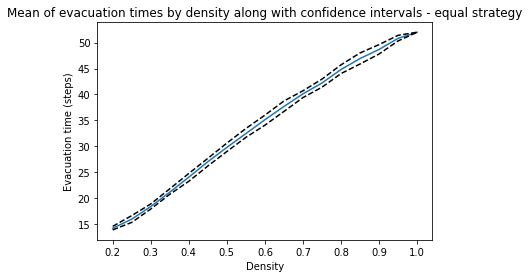

In [25]:
plt.figure()
plt.plot(list_density, lst_mean_equal)
plt.plot(list_density, lst_upper_confint_equal, 'k--')
plt.plot(list_density, lst_lower_confint_equal,'k--')
plt.title("Mean of evacuation times by density along with confidence intervals - equal strategy")
plt.xlabel("Density")
plt.ylabel("Evacuation time (steps)")
plt.show()

In [26]:
#Examining the confidence intervals
list_confint_random=[]
for i in range(len(lst_upper_confint)):
    confint = []
    confint.append([round(lst_lower_confint[i],2),round(lst_upper_confint[i],2)])
    list_confint_random.append(confint)
                

In [27]:
dict_random = {}
for i in range(len(list_density)):
    dict_random[round(list_density[i],2)] = list_confint_random[i]

In [28]:
dict_random

{0.2: [[17.27, 19.99]],
 0.25: [[20.99, 24.62]],
 0.3: [[25.6, 32.78]],
 0.35: [[30.52, 36.51]],
 0.4: [[33.95, 44.95]],
 0.45: [[41.25, 55.19]],
 0.5: [[45.82, 63.19]],
 0.55: [[47.91, 63.85]],
 0.6: [[53.86, 75.98]],
 0.65: [[57.81, 82.42]],
 0.7: [[61.04, 86.02]],
 0.75: [[63.03, 97.44]],
 0.8: [[70.92, 101.76]],
 0.85: [[64.62, 98.11]],
 0.9: [[72.09, 105.47]],
 0.95: [[65.06, 103.7]],
 1.0: [[75.9, 114.5]]}

In [29]:
list_confint_equal=[]
for i in range(len(lst_upper_confint_equal)):
    confint = []
    confint.append([round(lst_lower_confint_equal[i],2),round(lst_upper_confint_equal[i],2)])
    list_confint_equal.append(confint)
                

In [30]:
dict_equal = {}
for i in range(len(list_density)):
    dict_equal[round(list_density[i],2)] = list_confint_equal[i]

In [31]:
dict_equal

{0.2: [[13.87, 14.56]],
 0.25: [[15.32, 16.63]],
 0.3: [[17.9, 18.88]],
 0.35: [[20.74, 21.8]],
 0.4: [[23.25, 24.76]],
 0.45: [[26.2, 27.68]],
 0.5: [[28.99, 30.61]],
 0.55: [[31.72, 33.43]],
 0.6: [[34.07, 36.01]],
 0.65: [[36.72, 38.73]],
 0.7: [[39.4, 40.71]],
 0.75: [[41.4, 42.96]],
 0.8: [[44.02, 45.71]],
 0.85: [[45.87, 48.0]],
 0.9: [[47.8, 49.61]],
 0.95: [[50.32, 51.4]],
 1.0: [[52.0, 52.0]]}